In [1]:
# Change directory so that code in "src" directory is easily importable.
import os
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyathena import connect
from pyathena.pandas_cursor import PandasCursor

from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score,\
                            precision_score, recall_score, f1_score

pd.options.display.max_columns = 60
pd.options.display.max_rows = 600

# Define connection to DB
conn = connect(
    s3_staging_dir='s3://aws-athena-query-results-323906537337-us-east-1/',
    region_name='us-east-1',
    cursor_class=PandasCursor
    )
cursor = conn.cursor()

# 0 Data

## 0.1 loading 538 elo rating data

In [3]:
elo_data = pd.read_csv('runtime/datasets/nfl_elo.csv')
elo_data = elo_data[(elo_data.season == 2019)]
elo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 16274 to 16540
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            267 non-null    object 
 1   season          267 non-null    int64  
 2   neutral         267 non-null    int64  
 3   playoff         11 non-null     object 
 4   team1           267 non-null    object 
 5   team2           267 non-null    object 
 6   elo1_pre        267 non-null    float64
 7   elo2_pre        267 non-null    float64
 8   elo_prob1       267 non-null    float64
 9   elo_prob2       267 non-null    float64
 10  elo1_post       267 non-null    float64
 11  elo2_post       267 non-null    float64
 12  qbelo1_pre      267 non-null    float64
 13  qbelo2_pre      267 non-null    float64
 14  qb1             267 non-null    object 
 15  qb2             267 non-null    object 
 16  qb1_value_pre   267 non-null    float64
 17  qb2_value_pre   267 non-null 

In [4]:
# create a dictionary between team name and team id
team_dict = {'ARI':355, 'ATL':323, 'BAL':366, 'BUF':324, 'CAR':364, 'CHI':326, 'CIN':327, 'CLE':329, 'DAL':331,
       'DEN':332, 'DET':334, 'GB':335, 'HOU':325, 'IND':338, 'JAX':365, 'KC':339, 'LAC':357, 'LAR':343, 'MIA':345,
       'MIN':347, 'NE':348, 'NO':350, 'NYG':351, 'NYJ':352, 'OAK':341, 'PHI':354, 'PIT':356, 'SEA':361, 'SF':359,
       'TB':362, 'TEN':336, 'WSH':363}
team_dict=pd.DataFrame(pd.Series(team_dict) ).reset_index()
team_dict.columns = ['team','team_id']
team_dict

,team,team_id
0,ARI,355
1,ATL,323
2,BAL,366
3,BUF,324
4,CAR,364
5,CHI,326
6,CIN,327
7,CLE,329
8,DAL,331
9,DEN,332


In [5]:
# add team id for home/away team
elo_data = pd.merge(elo_data, team_dict, left_on='team1', right_on='team', how='left')
elo_data.drop('team', axis=1, inplace=True)
elo_data.rename(columns={'team_id':'team1_id'}, inplace=True)

elo_data = pd.merge(elo_data, team_dict, left_on='team2', right_on='team', how='left')
elo_data.drop('team', axis=1, inplace=True)
elo_data.rename(columns={'team_id':'team2_id'}, inplace=True)

In [6]:
# calculate team rolling VALUE rating
elo_data['team1_value_pre'] = elo_data.qb1_value_pre - elo_data.qb1_adj
elo_data['team2_value_pre'] = elo_data.qb2_value_pre - elo_data.qb2_adj

elo_data['team1_value_post'] = elo_data.team1_value_pre * 0.95 + elo_data.qb1_game_value * 0.05
elo_data['team2_value_post'] = elo_data.team2_value_pre * 0.95 + elo_data.qb2_game_value * 0.05

elo_data['home_win'] = elo_data.score1 > elo_data.score2

elo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 266
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              267 non-null    object 
 1   season            267 non-null    int64  
 2   neutral           267 non-null    int64  
 3   playoff           11 non-null     object 
 4   team1             267 non-null    object 
 5   team2             267 non-null    object 
 6   elo1_pre          267 non-null    float64
 7   elo2_pre          267 non-null    float64
 8   elo_prob1         267 non-null    float64
 9   elo_prob2         267 non-null    float64
 10  elo1_post         267 non-null    float64
 11  elo2_post         267 non-null    float64
 12  qbelo1_pre        267 non-null    float64
 13  qbelo2_pre        267 non-null    float64
 14  qb1               267 non-null    object 
 15  qb2               267 non-null    object 
 16  qb1_value_pre     267 non-null    float64
 1

In [ ]:
elo_data.playoff.unique() # 's'-> superball, 'w'-> wild card, 'c'->conference final, 'd'->division final
#elo_data.neutral.unique()

## 0.2 loading game data from S3

In [11]:
# from datalake football to query game level information
# query team game-level stats
# "team_aggregated_game_stats" table doesn't provide home team info
# "not_stats_data_games" table only contains one season data

simple_query = f'''
-- t1 and t2: ceate one record per game from pbp data
with t1 as
(
select
  ROW_NUMBER() OVER(partition by eventmetadata.gamecode) AS num_row, 
  season, eventmetadata, teammetadata
from datalakefootball.pbp
where leagueid='8'
),

t2 as
(
select
  cast(season as integer) season,
  --cast(FROM_UNIXTIME(eventmetadata.gamedateutcepoch) as DATE) date,
  DATE_FORMAT(FROM_UNIXTIME(eventmetadata.gamedateutcepoch), '%Y-%m-%d') date,
  eventmetadata.week, 
  eventmetadata.gamecode game_code, eventmetadata.eventtypeid as event_type_id,
  teammetadata[1].teamid team1_id, 
  --teammetadata[1].abbreviation team1,
  --teammetadata[1].score home_team_score,
  teammetadata[2].teamid team2_id 
  --teammetadata[2].abbreviation team2,
  --teammetadata[2].score away_team_score
from t1
where num_row=1 and eventmetadata.eventtypeid in (1,2) and season ='2019' 
order by game_code
),

-- t3 and t4 are created to decide previous game week for each team
t3 as
(
select
  *,
  ROW_NUMBER() OVER(partition by season, team_id order by week) AS num_row
from
  (select * from (select season, team1_id as team_id, week from t2)
   union
   select * from (select season, team2_id as team_id, week from t2))
),

t4 as
(
select c.season, c.team_id, c.week, p.week prev_week
from t3 as c
  left join t3 as p
  on c.season=p.season and c.team_id=p.team_id and c.num_row=p.num_row+1
 order by c.season, c.team_id, c.week
)

-- final game level table
select 
  t2.*, 
  COALESCE(home_table.prev_week,0) as team1_prev_week,
  COALESCE(away_table.prev_week,0) as team2_prev_week
from t2 
  left join t4 as home_table
  on t2.season=home_table.season and t2.team1_id=home_table.team_id and t2.week=home_table.week
  left join t4 as away_table
  on t2.season=away_table.season and t2.team2_id=away_table.team_id and t2.week=away_table.week
order by t2.season, t2.week
'''

if True:
    game_df = cursor.execute(simple_query).as_pandas()
    print(game_df.info())
else:
    print("Failed to query!")
    
# totaloffensiveplays = totalrushingattempts + totalpassattempts + totalsacksallowed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   season           267 non-null    Int64 
 1   date             267 non-null    object
 2   week             267 non-null    Int64 
 3   game_code        267 non-null    Int64 
 4   event_type_id    267 non-null    Int64 
 5   team1_id         267 non-null    Int64 
 6   team2_id         267 non-null    Int64 
 7   team1_prev_week  267 non-null    Int64 
 8   team2_prev_week  267 non-null    Int64 
dtypes: Int64(8), object(1)
memory usage: 21.0+ KB
None


## 0.3 loading QB data from S3

In [12]:
simple_query = f'''
with stats as (
select 
  --season, 
  eventmetadata.gamecode game_code, playerid player_id,
  --playerstats,
  playerstats.passingstats.completions pass_completions, 
  playerstats.passingstats.attempts pass_attempts,
  playerstats.passingstats.interceptions interceptions,
  playerstats.passingstats.yards pass_yards,
  playerstats.passingstats.sacked sacks,
  playerstats.passingstats.touchdowns pass_tds,
  COALESCE(playerstats.rushingstats.attempts, 0) rush_attempts,
  COALESCE(playerstats.rushingstats.yards, 0)rush_yards,
  COALESCE(playerstats.rushingstats.touchdowns, 0) rush_tds
from datalakefootball.player_stats_game
where 
  playerstats.passingstats is not null and 
  eventmetadata.eventtypeid in (1,2) and
  season='2019'
),

names as
(
select
  eventmetadata.gamecode game_code, teamid team_id, player.playerid player_id, 
  player.firstname qb_first_name, player.lastname qb_last_name
from 
  datalakefootball.player_aggregated_game_stats
where 
  player.positionid=8 and 
  totalpassattempts>=0 and 
  isstartingqb=1 and 
  eventmetadata.eventtypeid in (1,2) and
  season='2019'
)

select
    names.game_code, names.team_id, names.player_id, names.qb_first_name, names.qb_last_name,
    3.3 * (-2.2 * stats.pass_attempts + 3.7* stats.pass_completions + (stats.pass_yards / 5) + 
    11.3 * stats.pass_TDs - 14.1 * stats.interceptions - 8 * stats.sacks - 
    1.1 * stats.rush_attempts + 0.6 * stats.rush_yards + 15.9 * stats.rush_TDs)
    as qb_value
from 
  names
  left join stats
  on names.game_code=stats.game_code and names.player_id=stats.player_id

'''

if True:
    qb_df = cursor.execute(simple_query).as_pandas()
    print(qb_df.info())
else:
    print("Failed to query!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_code      540 non-null    Int64  
 1   team_id        540 non-null    Int64  
 2   player_id      540 non-null    Int64  
 3   qb_first_name  540 non-null    object 
 4   qb_last_name   540 non-null    object 
 5   qb_value       538 non-null    float64
dtypes: Int64(3), float64(1), object(2)
memory usage: 27.0+ KB
None


In [13]:
# merge game data with QB data
s3_df = pd.merge(game_df, qb_df, left_on=['game_code','team1_id'], right_on=['game_code','team_id'], how='left')
s3_df.rename(columns={'player_id':'qb1_id','qb_first_name':'qb1_first_name',
                      'qb_last_name':'qb1_last_name','qb_value':'qb1_value'}, inplace=True)
s3_df.drop(columns=('team_id'), inplace=True)

s3_df = pd.merge(s3_df, qb_df, left_on=['game_code','team2_id'], right_on=['game_code','team_id'], how='left')
s3_df.rename(columns={'player_id':'qb2_id','qb_first_name':'qb2_first_name',
                      'qb_last_name':'qb2_last_name','qb_value':'qb2_value'}, inplace=True)
s3_df.drop(columns=('team_id'), inplace=True)

s3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 272
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           273 non-null    Int64  
 1   date             273 non-null    object 
 2   week             273 non-null    Int64  
 3   game_code        273 non-null    Int64  
 4   event_type_id    273 non-null    Int64  
 5   team1_id         273 non-null    Int64  
 6   team2_id         273 non-null    Int64  
 7   team1_prev_week  273 non-null    Int64  
 8   team2_prev_week  273 non-null    Int64  
 9   qb1_id           273 non-null    Int64  
 10  qb1_first_name   273 non-null    object 
 11  qb1_last_name    273 non-null    object 
 12  qb1_value        272 non-null    float64
 13  qb2_id           273 non-null    Int64  
 14  qb2_first_name   273 non-null    object 
 15  qb2_last_name    273 non-null    object 
 16  qb2_value        272 non-null    float64
dtypes: Int64(10), fl

## 0.4 merge elo-rating and s3 data

In [14]:
#game_df.season.unique()
df = pd.merge(s3_df, elo_data, left_on=['season','team1_id','team2_id'], 
              right_on=['season','team1_id','team2_id'], how='left')

# Use approximation to handle game-date logging error
delta_days = pd.to_datetime(df.date_x)-pd.to_datetime(df.date_y)
df = df.loc[abs(delta_days.dt.days)<=1]
df.reset_index(drop=True, inplace=True)
df.drop(columns=('date_y'), inplace=True)
df.rename(columns={'date_x':'date'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            273 non-null    Int64  
 1   date              273 non-null    object 
 2   week              273 non-null    Int64  
 3   game_code         273 non-null    Int64  
 4   event_type_id     273 non-null    Int64  
 5   team1_id          273 non-null    Int64  
 6   team2_id          273 non-null    Int64  
 7   team1_prev_week   273 non-null    Int64  
 8   team2_prev_week   273 non-null    Int64  
 9   qb1_id            273 non-null    Int64  
 10  qb1_first_name    273 non-null    object 
 11  qb1_last_name     273 non-null    object 
 12  qb1_value         272 non-null    float64
 13  qb2_id            273 non-null    Int64  
 14  qb2_first_name    273 non-null    object 
 15  qb2_last_name     273 non-null    object 
 16  qb2_value         272 non-null    float64
 1

In [15]:
# estimate average QB values
id=df.week>=1
pd.concat([df[id].qb1_game_value, df[id].qb2_game_value], ignore_index=True).mean()

159.34056811091196

In [16]:
# filter out game entries with secondary QBs
# seems 538 got the starting QB for game 2142147 wrong!

id=(df[['qb1', 'qb1_first_name']].apply(lambda x: x[0].find(x[1]), axis=1)==-1) |\
    (df[['qb2', 'qb2_first_name']].apply(lambda x: x[0].find(x[1]), axis=1)==-1)
id = id & (df.game_code != 2142147)

df = df[~id]
df.shape

(267, 50)

In [ ]:
df[(df.team1_id==335) | (df.team2_id==335)][['team1','team2','qb1','qb2','qbelo1_pre','qbelo2_pre','qbelo1_post','qbelo2_post']]

# 1. Seasonal simulation

## 1.1 Version 1.0

In [ ]:
# In this version, a few adjustments are added for elo_diff calculation: 
#   home field adjustment, rest adjustment, playoff adj
# A simulation function is defined to calculate the results for each week of the season

In [17]:
# the simulation algo:
# one row represents one game
#   once the processing is done, the newly updated elo rating is recorded for both teams of the game
# when the whole season simulation is done, the simulation results are compared with those from 538

def elo_rating_calculation(elo1_pre, elo2_pre, row, K, version=1, team1_value=0, team2_value=0, 
                                      qb1_value=0, qb2_value=0):
    # calc basic elo diff rating
    elo_diff = elo1_pre - elo2_pre
        
    # calc home court adj
    if row.neutral == 0:
        elo_diff = elo_diff + 55

    # calc rest adj
    if (row.week-row.team1_prev_week) > (row.week-row.team2_prev_week):
        elo_diff = elo_diff + 25
    elif (row.week-row.team1_prev_week) < (row.week-row.team2_prev_week):
        elo_diff = elo_diff - 25

    # calc playoff adj
    if row.playoff==row.playoff:
        elo_diff = 1.2 * elo_diff
        
    # QB adjustment
    if version==2:
        #qb_adj = row.qb1_adj - row.qb2_adj
        qb1_adj = qb1_value - team1_value
        qb2_adj = qb2_value - team2_value
        qb_adj = qb1_adj - qb2_adj
        elo_diff = elo_diff + qb_adj
        qb1_value_post = 0.9 * qb1_value + 0.1 * row.qb1_value
        qb2_value_post = 0.9 * qb2_value + 0.1 * row.qb2_value
        team1_value_post = 0.95 * team1_value + 0.05 * row.qb1_value
        team2_value_post = 0.95 * team2_value + 0.05 * row.qb2_value
        if row.week==1:
            print(qb1_adj, qb2_adj, qb_adj, elo_diff)
    else:
        qb1_value_post,qb2_value_post,team1_value_post,team2_value_post=0,0,0,0

    # calc win-prob
    elo1_prob_s = 1/(10**(-elo_diff/400) + 1)
    elo2_prob_s = 1 - elo1_prob_s

    # calc post-game elo rating based on the game outcome
    score_delta = row.score1 - row.score2

    if row.score1 > row.score2:
        re1, re2 = 1, 0
        MoV_multiplier = np.log(score_delta + 1) * 2.2 / (2.2 + (elo1_pre-elo2_pre)*0.001)
    elif row.score1 < row.score2:
        re1, re2 = 0, 1
        MoV_multiplier = np.log(-score_delta + 1) * 2.2 / (2.2 + (elo2_pre-elo1_pre)*0.001)
    # there is some issue with the original design, for tie, it will lead to no elo score adj
    # but that is not in line with the original design
    else:
        re1, re2 = 0.5, 0.5            
        MoV_multiplier = np.log(0.5 + 1) * 2.2 / (2.2 - abs(elo1_pre-elo2_pre)*0.001)

    elo1_post = elo1_pre + K * (re1 - elo1_prob_s) * MoV_multiplier
    elo2_post = elo2_pre + K * (re2 - elo2_prob_s) * MoV_multiplier

    return (elo1_pre, elo2_pre, elo1_prob_s, elo2_prob_s, elo1_post, elo2_post,
           team1_value, team1_value_post, team2_value, team2_value_post,
           qb1_value, qb1_value_post, qb2_value, qb2_value_post)


In [18]:
def elo_rating_in_season_simulation(df_in, K=20, version=1):
    df = df_in.copy()
    
    df[['elo1_pre_s','elo2_pre_s', 'elo1_prob_s', 'elo2_prob_s', 'elo1_post_s','elo2_post_s']] = 0.0
    
    if version == 2:
        df[['team1_value_pre_s','team1_value_post_s','team2_value_pre_s','team2_value_post_s']] = 0.0
        df[['qb1_value_pre_s','qb1_value_post_s','qb2_value_pre_s','qb2_value_post_s']] = 0.0
    
    # A dictionary to keep currnet elo_rating states of each team
    elo_ratings={}
    
    qb_values={}
    team_values={}
    
    # defensive adjustment
    defense_ratings={}
    
    # simulation for each game
    for index, row in df.iterrows():
        
        # initialize elo_pre
        if row.team1_id in elo_ratings:
            elo1_pre = elo_ratings[row.team1_id]
        else:
            if version == 1:
                elo1_pre = row.elo1_pre
            else:
                elo1_pre = row.qbelo1_pre
            
        if row.team2_id in elo_ratings:
            elo2_pre = elo_ratings[row.team2_id]
        else:
            if version == 1:
                elo2_pre = row.elo2_pre
            else:
                elo2_pre = row.qbelo2_pre
        
        # initialize team_values
        team1_value, team2_value, qb1_value, qb2_value = 0, 0, 0, 0
        if version == 2:
            if row.team1_id in team_values:
                team1_value = team_values[row.team1_id]
                qb1_value   = qb_values[row.team1_id]
            else:
                team1_value = row.team1_value_pre
                qb1_value   = row.qb1_value_pre
                
            if row.team2_id in team_values:
                team2_value = team_values[row.team2_id]
                qb2_value   = qb_values[row.team2_id]
            else:
                team2_value = row.team2_value_pre
                qb2_value   = row.qb2_value_pre
                
        re=elo_rating_calculation(elo1_pre, elo2_pre, row, K, version, team1_value, team2_value, 
                                      qb1_value, qb2_value)
        
        elo_ratings[row.team1_id] = re[4] #elo1_post
        elo_ratings[row.team2_id] = re[5] #elo2_post
        
        #store the state variables at the end of each game
        df.loc[index:index,('elo1_pre_s','elo2_pre_s', 'elo1_prob_s', 'elo2_prob_s', 
                             'elo1_post_s','elo2_post_s',
                           'team1_value_pre_s','team1_value_post_s','team2_value_pre_s','team2_value_post_s',
                           'qb1_value_pre_s','qb1_value_post_s','qb2_value_pre_s','qb2_value_post_s')] = re
        
    return df

In [19]:
df['team2_def_value_adj']=df.qb1_game_value - df.qb1_value
df['team1_def_value_adj']=df.qb2_game_value - df.qb2_value

In [ ]:
df[(df.week>=1) & ((df.team1_id==335) | (df.team2_id==335))]\
[['week','team1','team2','qb1','qb2','qb1_value','qb2_value','qb1_game_value','qb2_game_value',
  #'team1_def_value_adj','team2_def_value_adj',
  #'qb1_value_pre','qb2_value_pre','qb1_value_post','qb2_value_post',
  #'qb1_adj','qb2_adj',
  'qbelo1_pre','qbelo2_pre','qbelo1_post','qbelo2_post',
 'team1_value_pre','team2_value_pre', 'team1_value_post','team2_value_post']]

In [23]:
df.iloc[91]

season                         2019
date                     2019-10-11
week                              6
game_code                   2142198
event_type_id                     1
team1_id                        348
team2_id                        351
team1_prev_week                   5
team2_prev_week                   5
qb1_id                        25347
qb1_first_name                  Tom
qb1_last_name                 Brady
qb1_value                264.330000
qb2_id                       879981
qb2_first_name               Daniel
qb2_last_name                 Jones
qb2_value                -56.430000
neutral                           0
playoff                         NaN
team1                            NE
team2                           NYG
elo1_pre                1704.784191
elo2_pre                1404.589395
elo_prob1                  0.891120
elo_prob2                  0.108880
elo1_post               1710.556989
elo2_post               1398.816596
qbelo1_pre              1693

In [21]:
# testing for 2017 season can show difference of QB
elo_rating_calculation(elo1_pre=1585.8, elo2_pre=1543.2, row=df.iloc[91], K=20)

(1585.8,
 1543.2,
 0.6368760375291475,
 0.36312396247085255,
 1607.822201769589,
 1521.177798230411,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0)

In [22]:
elo_rating_calculation(elo1_pre=1585.8, elo2_pre=1543.2, row=df.iloc[91], K=20, version=2)

(1585.8,
 1543.2,
 0.6368760375291475,
 0.36312396247085255,
 1607.822201769589,
 1521.177798230411,
 0,
 13.216500000000003,
 0,
 -2.8215,
 0,
 26.433000000000007,
 0,
 -5.643)

## 1.1 Version I

In [24]:
# The input is a data-frame for one season
re1 = elo_rating_in_season_simulation(df, version=1)

In [106]:
df1 = re1.loc[:,['team1_id','date','elo1_pre','elo_prob1','elo1_post','elo1_pre_s','elo1_prob_s','elo1_post_s']]
df2 = re1.loc[:,['team2_id','date','elo2_pre','elo_prob2','elo2_post','elo2_pre_s','elo2_prob_s','elo2_post_s']]

df1.columns = ['team_id', 'date', 'elo_pre', 'prob', 'elo_post', 'elo_pre_s', 'prob_s', 'elo_post_s']
df2.columns = ['team_id', 'date', 'elo_pre', 'prob', 'elo_post', 'elo_pre_s', 'prob_s', 'elo_post_s']

df1['win']=re1.loc[:,'home_win']
df2['win']=~re1.loc[:,'home_win']

re1_summary = pd.concat([df1, df2], axis=0, ignore_index=True)
re1_summary.sort_values(by=['team_id','date'], axis='index', inplace=True)

In [ ]:
df_summary[df_summary.team_id==339]

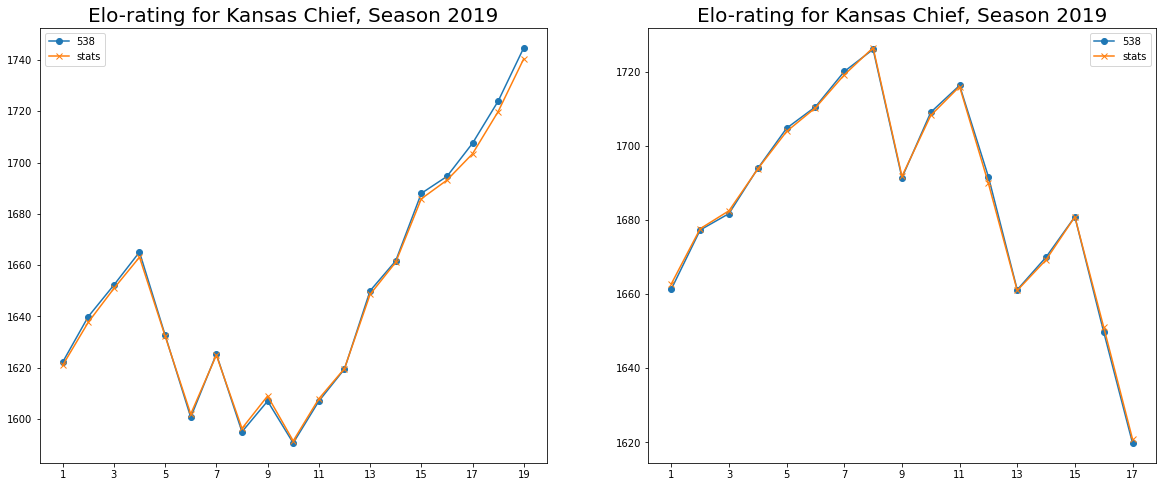

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(20)

ax1.plot(np.arange(1,20),re1_summary[re1_summary.team_id==339].elo_post.values, marker='o', label='538')
ax1.plot(np.arange(1,20),re1_summary[re1_summary.team_id==339].elo_post_s.values, marker='x', label='stats')
ax1.legend()
ax1.set_title("Elo-rating for Kansas Chief, Season 2019", fontsize=20)
ax1.set_xticks(np.arange(1,20,2))

ax2.plot(np.arange(1,18),re1_summary[re1_summary.team_id==348].elo_post.values, marker='o', label='538')
ax2.plot(np.arange(1,18),re1_summary[re1_summary.team_id==348].elo_post_s.values, marker='x', label='stats')
ax2.legend()
ax2.set_title("Elo-rating for Kansas Chief, Season 2019", fontsize=20)
ax2.set_xticks(np.arange(1,18,2))

In [108]:
label = df1.win
y1 = df1.prob
y2 = df1.prob_s

print(f'mse: {mean_squared_error(label, y1):.3} {mean_squared_error(label, y2):.3}')
print(f'mae: {mean_absolute_error(label, y1):.3} {mean_absolute_error(label, y2):.3}')
print(f"roc_auc: {roc_auc_score(label, y1):.3} {roc_auc_score(label, y2):.3}\n")

print(f"accuracy: {accuracy_score(label, y1>0.5):.3} {accuracy_score(label, y2>0.5):.3}")
print(f"precision: {precision_score(label, y1>0.5):.3} {precision_score(label, y2>0.5):.3}")
print(f"recall: {recall_score(label, y1>0.5):.3} {recall_score(label, y2>0.5):.3}")
print(f"f1: {f1_score(label, y1>0.5):.3} {f1_score(label, y2>0.5):.3}")

mse: 0.225 0.225
mae: 0.438 0.439
roc_auc: 0.688 0.684

accuracy: 0.64 0.644
precision: 0.617 0.624
recall: 0.813 0.799
f1: 0.702 0.7


In [ ]:
# it is much easier to use datalake DB, compute the time interval (in weeks) for each team between current week and 
# previous game week. The team with larger interval means extra rest

## 1.2 Version II

In [30]:
re2 = elo_rating_in_season_simulation(df, version=2)

1.428019208879988 -1.2221746056299878 2.6501938145099757 186.54841748450986
-0.07271733215999632 12.82243458572998 -12.895151917889976 31.021806412109967
2.6008034101500073 3.41230339560002 -0.8114999854500127 213.78500705455
14.39234981910002 6.970182024299959 7.42216779480006 -61.5738465251998
7.679015260289987 5.778882856559989 1.900132403729998 126.21775184373004
4.648537297800004 -1.3907580149099772 6.0392953127099815 178.81346359271012
5.383617580440017 11.744404700490009 -6.3607871200499915 126.38514213995015
-2.3921679483900107 -27.587566727490014 25.195398779100003 155.91084694909995
5.7083328201899945 -4.964783410620015 10.67311623081001 -13.991813089190046
-3.553793322420006 2.1593142954899918 -5.713107617909998 5.948086162090078
5.972961817350011 2.878459528890005 3.0945022884600064 99.35228577845984
1.4555715309300012 -2.0256502975500155 3.4812218284800167 -18.15733260151987
2.1512597515200014 0.6191984472299907 1.5320613042900106 21.511259264289976
12.770916508679989 -9.2

In [109]:
df1 = re2.loc[:,['team1_id','date','qbelo1_pre','qbelo_prob1','qbelo1_post','elo1_pre_s','elo1_prob_s','elo1_post_s']]
df2 = re2.loc[:,['team2_id','date','qbelo2_pre','qbelo_prob2','qbelo2_post','elo2_pre_s','elo2_prob_s','elo2_post_s']]

df1.columns = ['team_id', 'date', 'elo_pre', 'prob', 'elo_post', 'elo_pre_s', 'prob_s', 'elo_post_s']
df2.columns = ['team_id', 'date', 'elo_pre', 'prob', 'elo_post', 'elo_pre_s', 'prob_s', 'elo_post_s']

df1.loc[:,'win']=re2.loc[:,'home_win']
df2.loc[:,'win']=~re2.loc[:,'home_win']

re2_summary = pd.concat([df1, df2], axis=0, ignore_index=True)
re2_summary.sort_values(by=['team_id','date'], axis='index', inplace=True)

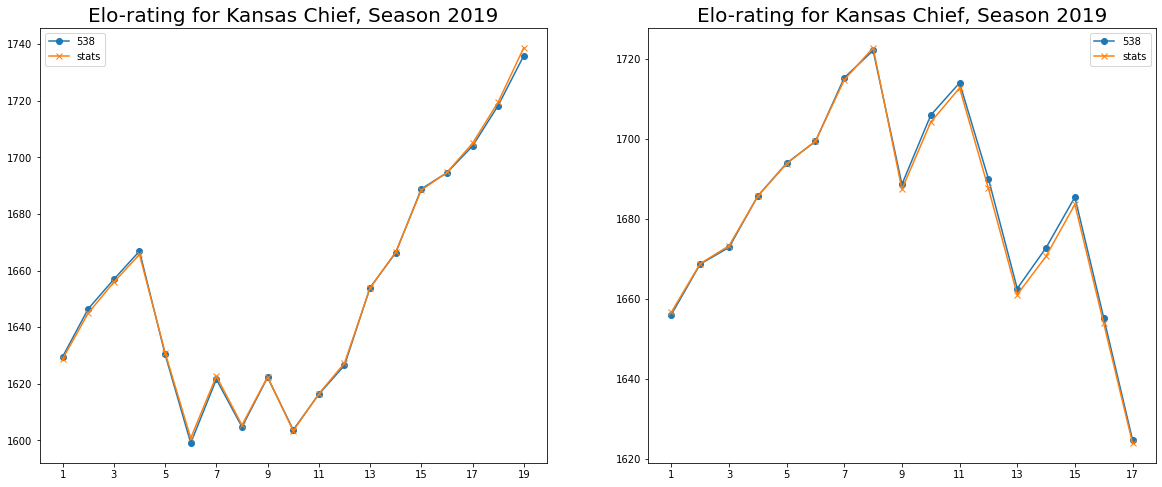

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(20)

ax1.plot(np.arange(1,20),re2_summary[re1_summary.team_id==339].elo_post.values, marker='o', label='538')
ax1.plot(np.arange(1,20),re2_summary[re1_summary.team_id==339].elo_post_s.values, marker='x', label='stats')
ax1.legend()
ax1.set_title("Elo-rating for Kansas Chief, Season 2019", fontsize=20)
ax1.set_xticks(np.arange(1,20,2))

ax2.plot(np.arange(1,18),re2_summary[re1_summary.team_id==348].elo_post.values, marker='o', label='538')
ax2.plot(np.arange(1,18),re2_summary[re1_summary.team_id==348].elo_post_s.values, marker='x', label='stats')
ax2.legend()
ax2.set_title("Elo-rating for Kansas Chief, Season 2019", fontsize=20)
ax2.set_xticks(np.arange(1,18,2))

In [110]:
label = df1.win
y1 = df1.prob
y2 = df1.prob_s

print(f'mse: {mean_squared_error(label, y1):.3} {mean_squared_error(label, y2):.3}')
print(f'mae: {mean_absolute_error(label, y1):.3} {mean_absolute_error(label, y2):.3}')
print(f"roc_auc: {roc_auc_score(label, y1):.3} {roc_auc_score(label, y2):.3}\n")

print(f"accuracy: {accuracy_score(label, y1>0.5):.3} {accuracy_score(label, y2>0.5):.3}")
print(f"precision: {precision_score(label, y1>0.5):.3} {precision_score(label, y2>0.5):.3}")
print(f"recall: {recall_score(label, y1>0.5):.3} {recall_score(label, y2>0.5):.3}")
print(f"f1: {f1_score(label, y1>0.5):.3} {f1_score(label, y2>0.5):.3}")

mse: 0.22 0.22
mae: 0.43 0.431
roc_auc: 0.7 0.7

accuracy: 0.644 0.648
precision: 0.626 0.632
recall: 0.784 0.777
f1: 0.696 0.697
